# Bias on Wikipedia

The aim of this experiment is to analyze the bias in Wikiepdia in data about countries, especially related to data about their politicians. We analyse both quantitatively where we compare the count of articles related to the country's population as well as the qualitatively where we compare the relative quality of the article as returned by the ORES service. 

# Data Acquisition 

The first source of our data is the Wikipedia data for politicians by their country and the Revision ID of the latest edit of the Wikipedia article on them. This data can be downloaded at https://figshare.com/articles/Untitled_Item/5513449

We download this data and read the csv (page_data.csv) present in country/data folder from the downloaded ZIP. This code is the original given to us as part of the assignment from the course Data 512 as it does what we need perfectly.

In [1]:
## getting the data from the CSV files and converting into a list
import csv
import pandas as pd

data = []
with open('page_data.csv', encoding='utf8') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data.append([row[0],row[1],row[2]])

The next source of our data is ORES API: https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}
This API gives the quality of the Wikipedia article as shown here in this example.

In [2]:
import requests
import json

#The endpoint for ORES API
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
headers = {'User-Agent' : 'https://github.com/SalikWarsi', 'From' : 'salikw@uw.edu'}

params = {'project' : 'enwiki',
          'model' : 'wp10',
          'revid' : '797882120'
          }

api_call = requests.get(endpoint.format(**params))
response = api_call.json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "enwiki": {
        "models": {
            "wp10": {
                "version": "0.5.0"
            }
        },
        "scores": {
            "797882120": {
                "wp10": {
                    "score": {
                        "prediction": "Start",
                        "probability": {
                            "B": 0.0325056273665757,
                            "C": 0.10161634736900718,
                            "FA": 0.003680032854794337,
                            "GA": 0.021044772033944954,
                            "Start": 0.8081343649161963,
                            "Stub": 0.033018855459481376
                        }
                    }
                }
            }
        }
    }
}


We can query this API and parse the JSON response to get the predicted Quality Score of the revision edit from ORES as shown next in this example.

In [3]:
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
headers = {'User-Agent' : 'https://github.com/SalikWarsi', 'From' : 'salikw@uw.edu'}

params = {'project' : 'enwiki',
          'model' : 'wp10',
          'revid' : '797882120'
          }

response = requests.get(endpoint.format(**params))
json_data = json.loads(response.text)
print(json_data['enwiki']['scores'][params['revid']]['wp10']['score']['prediction'])

Start


We can see that we were able to extract the prediction as "Start"

Now we read the CSV we read earlier (except first row which is the column titles) and for each of the Revision Ids in that table we query the ORES API and after parsing the JSON store the result (Quality) in a new list. 

Finally we combine all the data into a pandas data frame and write it to a csv file: **en-wikipedia_politician_article.csv** 

**Note: This takes hours to run so be careful running it.** The stored CSV file is there so we can directly start after this step. This is also why I put it under try-except as I was occaisonally getting an error. This error was due to 2 revision IDs (807367030 : Jalal Movaghar of Iran,807367166: Mohsen Movaghar of Iran) that returned that these revision IDs couldn't be identified by ORES. These IDs I have skipped.

In [8]:
#Now we read each data from csv row (except the first which is the header) 
#and query the ORES service for Quality score finally converting it into a csv
countries, politicians, revids, quality = [], [], [], []

#Reading each row from the csv file earlier read 
#We start from row 1 not 0 as row 0 is the heading of the columns
for row in data[1:]:
    try:
        # We call the ORES API with the revision ID
        params = {'project' : 'enwiki',
              'model' : 'wp10',
              'revid' : row[2]
              }
        response = requests.get(endpoint.format(**params))
        json_data = json.loads(response.text)
        #This step parses the JSON and extracts the score and adds it to the list
        quality.append(json_data['enwiki']['scores'][params['revid']]['wp10']['score']['prediction'])
        countries.append(row[0])
        politicians.append(row[1])
        revids.append(row[2])
        rowcount = rowcount+1
    except:
        rowcount = rowcount+1
        print("Exception Occured for rev_ID", row[2])
#Write to a file
#First convert to data frame

print("Writing to File")
dataFrame = pd.DataFrame([countries, politicians, revids, quality]).T
dataFrame.columns = ["politician", "country", "revid", "quality"]

#Write Data frame to csv
dataFrame.to_csv('en-wikipedia_politician_article.csv',index=False)
print("Written")

Exception Occured  for rev_ID 807367030
Exception Occured  for rev_ID 807367166
Writing to File
Written


The Third data source is the Population data by Country from the Population Referece Bureau: http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14

It can be downloaded directly from that website using the Excel button on top right. This is stored as: **Population Mid-2015.csv**

# Data Processing

We now have 2 csv files that we will combine and clean. These are
1. en-wikipedia_politician_article.csv
2. Population Mid-2015.csv

In [18]:
#Reading Politician article data
Politicians = pd.read_csv('en-wikipedia_politician_article.csv')

#Reading Population CSV. Here the first line is not part of the table so we skip it
# Also by defining the separartor and thousands we read the population as an integer
Population = pd.read_csv('Population Mid-2015.csv', header=1, sep= ",", thousands=',')

# Keeping only the columns we need: country and data (Population of the country in mid 2015)
Population = Population[['Location', 'Data']]

# We combine the 2 data sets
# We use an inner join as we only want those rows where we have data from both tables
Combined = Politicians.merge(Population, left_on='country', right_on='Location', how='inner')

Here we notice that some politicians are part of multiple countries. However it is possible that 2 different people have the same name. Therefore we use Revision ID of the wikipedia article as a unique identifier. 

We count number of rows per Revision ID and we only take those revision ids that have 1 row. Then we do an inner join to only include those which are unique

In [19]:
# Counting rows per Revision ID
rowsPerPolitician = pd.DataFrame({'count' : Combined.groupby( ['revid'] ).size()}).reset_index()

#Only keeping those revision ID with 1 row only
uniquePoliticians = rowsPerPolitician[rowsPerPolitician['count'] == 1]

#Merging with Combined with an inner join to keep only unique politicians
Combined = Combined.merge(uniquePoliticians, left_on='revid', right_on='revid', how='inner')


Finally we extract only the columns we need and rename them before writing to a csv file: **PoliticiansArticleQualityWithCountryPopulation.csv**

In [20]:
Combined = Combined[['country', 'politician', 'revid', 'quality', 'Data']]
Combined.columns = ['country', 'article_name', 'revision_id', 'article_quality', 'population']

Combined.to_csv('PoliticiansArticleQualityWithCountryPopulation.csv',index=False, encoding='utf8')

# Data Analysis

The first thing we do is read the data into a panda dataframe

In [2]:
#Importing Library
import pandas as pd

#Reading the csv
data = pd.read_csv('PoliticiansArticleQualityWithCountryPopulation.csv', encoding='utf8')

Now we try to find number of Politician Articles divided by the population of the country for each country.
As earlier during data processing we have removed any article that exists more than once, by counting the number of rows in our data set per country we get number of Politician Articles for that country.

Similarly we could find the mean population value per country as for each country we already have a unique population value.

In [3]:
articlesPerCountry = pd.DataFrame({'articles' : data.groupby( ['country'] ).size(),
                               'population' : data.groupby( ['country'] )['population'].mean()}).reset_index()

# Find the ratio of Articles per Population
articlesPerCountry['PoliticianArticlesPerPopulation'] = articlesPerCountry['articles'] / articlesPerCountry['population']



In [4]:
# We now sort the data according this calculated ratio
articlesPerCountry.sort_values(by='PoliticianArticlesPerPopulation', ascending=False, inplace=True)

Now as its sorted in descending order we take the first 10 values as the top 10 ratios and plot a bar chart

Populating the interactive namespace from numpy and matplotlib


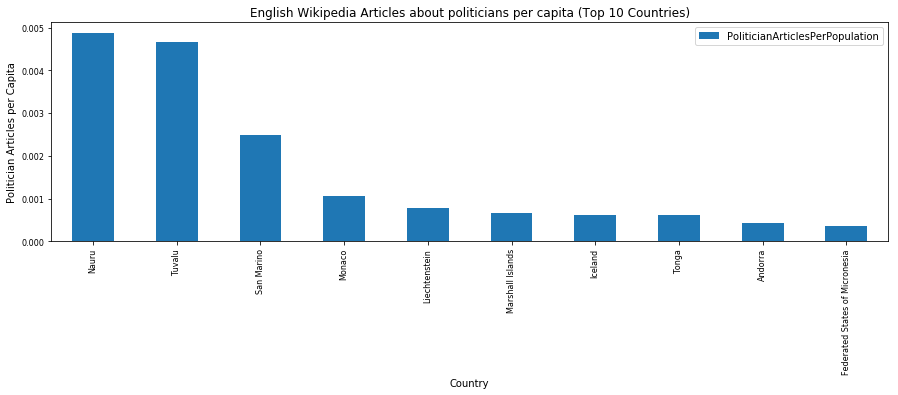

In [5]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)

#Taking top 10 values
articlesPerCountryTop = articlesPerCountry[:10]

#Creating plot
articlesPerCountryTop.plot.bar(x='country', y = 'PoliticianArticlesPerPopulation',fontsize = 8)
plt.subplots_adjust(bottom=0.5)
plt.xlabel('Country')  # Add a label to the x-axis
plt.ylabel('Politician Articles per Capita')  # Add a label to the y-axis
plt.title('English Wikipedia Articles about politicians per capita (Top 10 Countries)')  # Add a plot title
plt.savefig('Top10ArticlesPerCapita.png')
plt.show()

Similarly we create a barchart for the bottom 10 countries for that ratio and also show the sorted list

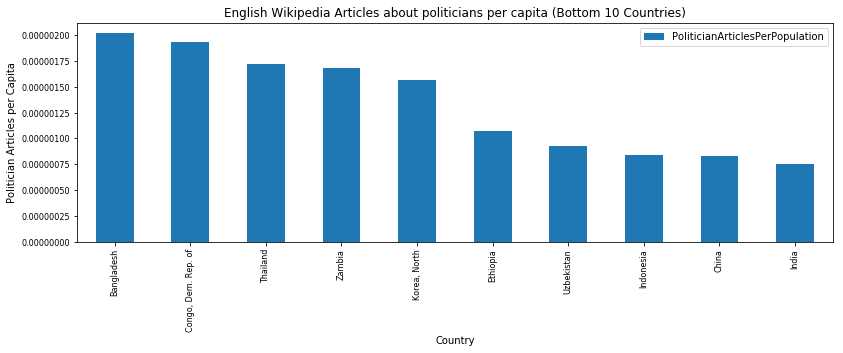

                 country  PoliticianArticlesPerPopulation
13            Bangladesh                     2.019812e-06
38   Congo, Dem. Rep. of                     1.936182e-06
166             Thailand                     1.719869e-06
185               Zambia                     1.680249e-06
86          Korea, North                     1.561062e-06
53              Ethiopia                     1.069813e-06
180           Uzbekistan                     9.267902e-07
74             Indonesia                     8.406911e-07
34                 China                     8.294944e-07
73                 India                     7.533687e-07


In [9]:
articlesPerCountryBottom = articlesPerCountry[-10:]

articlesPerCountryBottom.plot.bar(x='country', y = 'PoliticianArticlesPerPopulation',fontsize = 8)
plt.subplots_adjust(bottom=0.5,left=0.2)
plt.xlabel('Country')  # Add a label to the x-axis
plt.ylabel('Politician Articles per Capita')  # Add a label to the y-axis
plt.title('English Wikipedia Articles about politicians per capita (Bottom 10 Countries)')  # Add a plot title


plt.savefig('Bottom10ArticlesPerCapita.png')
plt.show()

### Analysis

We can see the highest ranked countries for those are some of the smallest countries in population while most of the countries at the bottom of this ranking have a high population. Even so countries like USA which have a very high population (3rd highest) still don't figure at the very bottom while some countries like Uzbekistan ( which has a realtively small population) still have a very low ratio. This could indicate bias against countries like Uzbekistan indicating that they might have lesser number of politicains listed in English Wikipedia than they should.

However it is important to note that the size of a country's parliament (or other governing body) which might indicate number of famous politicians is not directly proportional to their population. For example Tuvalu's population is less than 12000 while that of India is more 1.2 billion. However, as seen in https://en.wikipedia.org/wiki/Parliament_of_Tuvalu while their parliament has 15 members, India's doesn't have 150,000 members of parliaments. This could indicate why smaller countries tend to have higher ratios.

## Quality Articles

We then say that a article is high quality if it's quality rating is **FA** or **GA**.

Then for each country we calculate how much proportion of the articles are highquality and we plot the top 10 and the bottom 10.

We first create a new Variable in our data that denotes this articles is high quality

In [27]:
data['IsHighQuality'] = (data['article_quality'] == 'FA') | (data['article_quality'] == 'GA')

We then calculate the proportion of articles which are high quality for each country and we sort by this proportion. We use population of the country to break ties.

In [28]:
qualityPerCountry = pd.DataFrame({'population' : data.groupby( ['country'] )['population'].mean(),
                                  'HighQualityProportion' : data.groupby( ['country'] )['IsHighQuality'].mean()}).reset_index()
qualityPerCountry.sort_values(by=['HighQualityProportion', 'population'], ascending=[False,True], inplace=True)

Now we take the top 10 and plot a bar chart

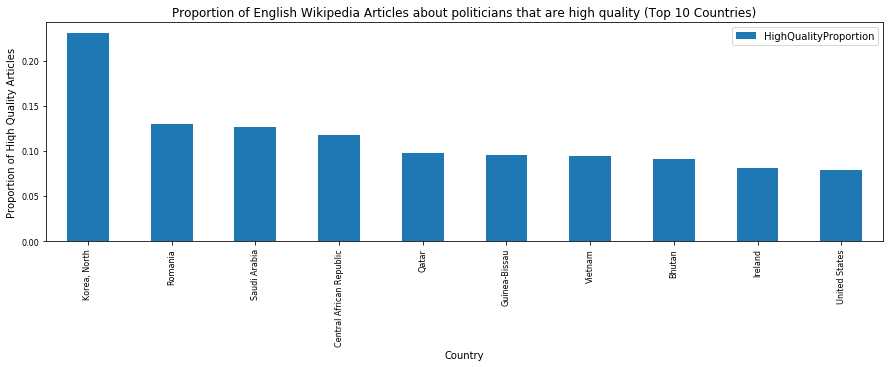

In [29]:
qualityPerCountryTop = qualityPerCountry[:10]

qualityPerCountryTop.plot.bar(x='country', y = 'HighQualityProportion',fontsize = 8)
plt.subplots_adjust(bottom=0.5)
plt.xlabel('Country')  # Add a label to the x-axis
plt.ylabel('Proportion of Hiqh Quality Articles')  # Add a label to the y-axis
plt.title('Proportion of English Wikipedia Articles about politicians that are high quality (Top 10 Countries)')  # Add a plot title


plt.savefig('Top10QualityArticleRatio.png')
plt.show()

Instead of showing a barchart, I observed that 39 countries have 0 High Quality articles about their politicians.
These are listed here

In [32]:
bottomCountries = qualityPerCountry[qualityPerCountry['HighQualityProportion'] == 0 ]
print("The countries with 0 high quality articles are:")
print(bottomCountries['country'])

The countries with 0 high quality articles are:
120                             Nauru
141                        San Marino
97                      Liechtenstein
113                            Monaco
107                  Marshall Islands
46                           Dominica
3                             Andorra
5                 Antigua and Barbuda
146                        Seychelles
54     Federated States of Micronesia
168                             Tonga
85                           Kiribati
142             Sao Tome and Principe
58                      French Guiana
14                           Barbados
17                             Belize
11                            Bahamas
65                         Guadeloupe
30                         Cape Verde
158                          Suriname
151                   Solomon Islands
69                             Guyana
36                            Comoros
45                           Djibouti
159                         Swaziland
12

### Analysis

Here we see that while for some countries almost 1/8th of the articles about their politicians have a high quality, for many others there are 0 articles that have a high quality. This indicates the imbalance in coverage in English Wikipedia articles and shows bias

# Possible Issues
There could be some issues in this analysis. As shown in https://figshare.com/articles/Untitled_Item/5513449 only 1 level of nesting was used to get Wikipedia articles from English Wikipedia. This might have led to us missing some articles and therefore corrupted our analysis.

Also when joining using countries between the data sources some countries had minor difference in names, which meant that they were removed from the analysis. Also there are some countries in either data source, not present in the other.